## Contrastive learning for object recognition
##### Written by Andrew F. Luo under the guidance of Leila Wehbe in 2024

### What is contrastive learning?
Contrastive learning is often also known as "self-supervised learning (SSL)" and has historically been known as "metric learning". The essence of contrastive/metric learning is that instead of outputting a classification one-hot/softmax vector, or outputting a regression value -- you instead output an high dimensional embedding directly.

Here is an example: Given multiple data points from a single class (for example three photos of you for different viewpoints) and different class or classes (for example 10 photos, from one/multiple people who are not you) -- you want the three embeddings from your photos to be closer together to each other while being farther away from the ten embeddings from the different classes.

Hence the name "metric learning", where you seek to learn a metric/distance that fits the constraints of the data.

### Why contrastive learning?
It may not be immediately obvious why you would want to do contrastive/metric learning. Can't you just use a giant 1000 class ImageNet trained classifier and recognize every image? However, metric learning is useful when the number of classes is not known ahead of time. For example, if I wanted a network to recognize human faces, however there are 7 billion people on this planet which makes it impossible for you to train a classification network with 7 billion output neurons. However, I can train a network that outputs a high dimensional embedding for each image. Now, given a reference image of a person, your network can decide if the new photo is close to or farther away from the reference image.


### How is contrastive learning used in practice?
Nearly all vision foundation models (DINO and DINOv2, CLIP and all CLIP derivatives including OpenCLIP/EVA-CLIP) are trained using contrastive losses. DINO/v2 is trained on images alone, while CLIP is trained on a combination of images and text.

When only images are used, the contrastive learning loss is applied to augmentations of the same image. Examples include crops/flips/rotations of images -- when used in the way, the augmentations are called a "pretext task". Typically, augmentations of the same image are treated as instances where the embeddings should be the same. So for example, a network should recognize a photo of you, and a photo of you flipped (or brightness changed, or noise added, or changed to black and white) as a photo of the same person.

When images and text are used together as in CLIP, you have images and captions of those images -- for example the caption "A photo of a dog" may be matched to a picture of a blue heeler puppy. These captions are typicalled scraped from online sources, and collected into datasets like LAION-2B/COYO-700M/CommonCrawl. While these captions are typically not high quality, having billions of them do seem to mitigate this issue. When contrastive learning is used in this case, typically a dual encoder is used -- one for text, and one for the image. The network is trained using a loss which minimizes the distance between the correct text and image pair, while distances between incorrect text and image pairs are maximized. For example -- the caption "A photo of a dog" and the picture of the blue heeler puppy should have embeddings that are close, while the caption should be far away from a picture of a cat. Often times, normalized dot-product (cosine similarity), angular distance (Universal Sentence Encoder
,) euclidean distance, or squared euclidean distance are applied to compute the "distance" of the embeddings.


### Terms defined and other stuff
* Positive pair -- This means two data points that should be close together in embedding space. For example two photos of you in different lighting conditions
* Negative pair -- This means two data points that should be far away in embedding space. For example, a photo of you versus a photo of a dog (assuming you are not a dog). Note that positive pairs/negative pairs don't have to be images. You could have a picture and the matching text be a positive pair as well. Recent work has also moved to positive pairs defined using an older version of the encoder (Google Momentum contrast or EMA contrastive)
* Pretext task -- In computer vision, this refers to how you augment images to get positive pairs.
* Hard positive/negative mining -- This refers to a practice where positive/negative pairs where the network struggles are used to trained the network with more loss in some way.
* InfoNCE -- This is one of the most common contrastive losses [1,2,3,4] which was proposed in similar ways multiple times by different authors. It is a cross-entropy loss of classifying
the correct positive pair out froma pool of pairs. Note there are variants like MIL-NCE which allow for multiple positive pairs.
* Recommended reading: "A Metric Learning Reality Check" -- This paper shows that most contrastive/metric learning losses perform very similarly


References:

[1] Unsupervised feature learning via non-parametric
instance discriminatio (2018)

[2] Representation learning with contrastive predictive coding (2018)

[3] A simple framework for contrastive learning of visual representations (2020

[4] Improved Deep Metric Learning with
Multi-class N-pair Loss Objectiv (2016)e)

[4] Noise-contrastive
estimation: A new estimation principle for unnormalize
statistical mode (2010)lsn

First we will import the necessary packages.

The allow tf32 flags will accelerate the process at the cost of lower precision. By default pytorch enables this for cudnn (conv) but not for matmul.

PCA/TSNE are just tools we will use for visualization.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# !gzip -d *.gz

First, we will define the network blocks we want to use.

Note that Pytorch modules MUST inherit from the `torch.nn.Module` class! After you define your own class, you MUST call `super().__init__()`. This ensures that network sub-modules are correctly registered. Note you can also use functions like `ModuleList`, `register_parameter`, `register_module`, and `register_buffer`.

First is a mini_residual block. In practice this follows the new residual block design with prenorm proposed by Kaiming. We also use LeakyReLU, this activation is more common in GANs where non-zero gradients are needed.

Second, is the full model which uses a stack of residual blocks. In pytorch, `nn.Sequential` are called from first to last.

In [ ]:
class mini_residual(nn.Module):
    # Follows "Identity Mappings in Deep Residual Networks", uses layernorm instead of batchnorm, uses leakyReLU instead of ReLU
    def __init__(self, feat_in=128, feat_out=128, feat_hidden=256, use_norm=True):
        super().__init__()
        if use_norm:
            self.block = nn.Sequential(nn.LayerNorm(feat_in), nn.LeakyReLU(negative_slope=0.1),
                                      nn.Linear(feat_in, feat_hidden), nn.LayerNorm(feat_hidden),
                                      nn.LeakyReLU(negative_slope=0.1), nn.Linear(feat_hidden, feat_out))
        else:
            self.block = nn.Sequential(nn.LeakyReLU(negative_slope=0.1),nn.Linear(feat_in, feat_hidden),
                                      nn.LeakyReLU(negative_slope=0.1), nn.Linear(feat_hidden, feat_out))
        if feat_in!=feat_out:
            self.bypass = nn.Linear(feat_in, feat_out)
        else:
            self.bypass = nn.Identity()

    def forward(self, input_data):
        return self.block(input_data) + self.bypass(input_data)


class Model(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, num_blocks=4):
        super().__init__()
        self.in_proj = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.Sequential(*[mini_residual(feat_in=hidden_dim, feat_out=hidden_dim, feat_hidden=hidden_dim) for i in range(num_blocks)])
        self.out = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        in_proj_out = self.in_proj(x)
        hidden_out = self.hidden(in_proj_out)
        return self.out(hidden_out)

In [ ]:
# from pytorch_metric_learning import losses
# loss_func = losses.NTXentLoss()

Now we will define the loss. This is code from the pytorch metric learning package. We have extracted it out and put it here for clarity.

We will be implementing a variant of InfoNCE. InfoNCE is the most popular contrastive/metric loss, and is used in networks like OpenAI's CLIP.

Typically InfoNCE needs very large batch sizes (like 128 or even higher). We will implement a variant of InfoNCE more suitable for small batch sizes here from the "Decoupled Contrastive Learning" paper. It basically removes the positive component from the denominator.

In [ ]:
# This is code from the pytorch metric learning package
# Extracted out so it is clear what it is doing

def neg_inf(dtype):
    return torch.finfo(dtype).min


def small_val(dtype):
    return torch.finfo(dtype).tiny

def to_dtype(x, tensor=None, dtype=None):
    if not torch.is_autocast_enabled():
        dt = dtype if dtype is not None else tensor.dtype
        if x.dtype != dt:
            x = x.type(dt)
    return x

def get_matches_and_diffs(labels, ref_labels=None):
    if ref_labels is None:
        ref_labels = labels
    labels1 = labels.unsqueeze(1)
    labels2 = ref_labels.unsqueeze(0)
    matches = (labels1 == labels2).byte()
    diffs = matches ^ 1
    if ref_labels is labels:
        matches.fill_diagonal_(0)
    return matches, diffs

def get_all_pairs_indices(labels, ref_labels=None):
    """
    Given a tensor of labels, this will return 4 tensors.
    The first 2 tensors are the indices which form all positive pairs
    The second 2 tensors are the indices which form all negative pairs
    """
    matches, diffs = get_matches_and_diffs(labels, ref_labels)
    a1_idx, p_idx = torch.where(matches)
    a2_idx, n_idx = torch.where(diffs)
    return a1_idx, p_idx, a2_idx, n_idx

def cos_sim(input_embeddings):
    # batch, dim
    normed_embeddings = torch.nn.functional.normalize(input_embeddings, dim=-1)
    return normed_embeddings@normed_embeddings.t()

def dcl_loss(pos_pairs, neg_pairs, indices_tuple,temperature=0.07):
    # This is the modified InfoNCE loss called "Decoupled Contrastive Learning" for small batch sizes
    # Basically You remove the numerator from the sum to the denominator

    a1, p, a2, _ = indices_tuple

    if len(a1) > 0 and len(a2) > 0:
        dtype = neg_pairs.dtype
        pos_pairs = pos_pairs.unsqueeze(1) / temperature
        neg_pairs = neg_pairs / temperature
        n_per_p = to_dtype(a2.unsqueeze(0) == a1.unsqueeze(1), dtype=dtype)
        neg_pairs = neg_pairs * n_per_p
        neg_pairs[n_per_p == 0] = neg_inf(dtype)

        max_val = torch.max(
            pos_pairs, torch.max(neg_pairs, dim=1, keepdim=True)[0]
        ).detach()
        numerator = torch.exp(pos_pairs - max_val).squeeze(1)
        denominator = torch.sum(torch.exp(neg_pairs - max_val), dim=1)
        log_exp = torch.log((numerator / denominator) + small_val(dtype))
        return -log_exp
    return 0

def pair_based_loss(mat, indices_tuple, lossfunc):
    a1, p, a2, n = indices_tuple
    pos_pair, neg_pair = [], []
    if len(a1) > 0:
        pos_pair = mat[a1, p]
    if len(a2) > 0:
        neg_pair = mat[a2, n]
    return lossfunc(pos_pair, neg_pair, indices_tuple)


# dummy_labels = torch.from_numpy(np.array([1,1,2,3,2,4]))
# demo_matches, demo_diffs = get_matches_and_diffs(labels=dummy_labels)
# results = get_all_pairs_indices(labels=dummy_labels)
# final_loss = pair_based_loss(torch.randn(6,6),results, None)

Now we will make the Pytorch dataset object, this defines how data is loaded from disk for each batch, and what transform you want to apply. Note that you do not have to use torchvision transforms. It is very common to write your own transform code in the dataset object.

Download and extract the data here:
https://github.com/golbin/TensorFlow-MNIST/tree/master/mnist/data

Run the following

`!gzip -d ./t10k-images-idx3-ubyte.gz`

`!gzip -d ./t10k-labels-idx1-ubyte.gz`

`!gzip -d ./train-images-idx3-ubyte.gz`

`!gzip -d ./train-labels-idx1-ubyte.gz`

And copy the files into `./MNIST/raw`

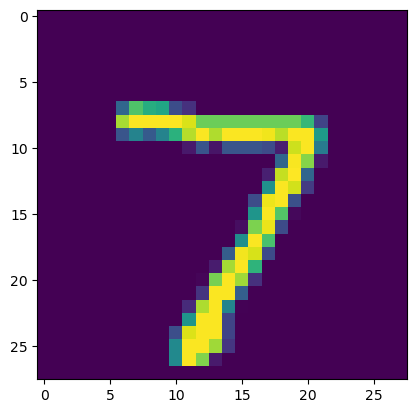

7


In [ ]:
mnist_transforms=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
test_dset = torchvision.datasets.MNIST("./", train=False, transform=mnist_transforms)


height = int(784**0.5)
width = height
idx = 0
data_point = test_dset[idx]
plt.imshow(data_point[0][0].numpy())
plt.show()
print(data_point[1])

Now we will make the mode. And we will move it to the device you want. Note that in pytorch, calling `.to(device)` on a module acts on the module itself, as in it is an inplace operation. However for pytorch tensors directly (if you don't call this function on a module) it is not inplace.

In [ ]:
mynet = Model(in_dim=784, out_dim=128, hidden_dim=256)
device = "cuda"
# device="cpu"
_ = mynet.to(device)

Let us create a test dataloader, and see what the untrained network gives us in terms of representations for each number. We will compute the cosine similarity for each written character WITHIN the same class (we set the diagonal to np.nan to avoid comparing a written character to itself).

We will also compute the cosine similarity for each written character across the classes.

You will see there is not much difference, this is expected as the network is untrained.

You should have a habit of calling network.eval() before evaluating a network, this is also an inplace operation. This will tell pytorch to freeze some buffers (like in batchnorm) and disable dropout.

We use `torch.inference_mode()` here, this disables gradient computation and speeds up the testing process. However this may break some features, if it fails you can replace it with `torch.no_grad()`.

Within class 0.5904283274468091 cosine similarity
Within class 0.7625138975267515 cosine similarity
Within class 0.59739407135095 cosine similarity
Within class 0.6079534254893844 cosine similarity
Within class 0.5649694741507486 cosine similarity
Within class 0.5765554426994025 cosine similarity
Within class 0.6268238696775826 cosine similarity
Within class 0.6172776955280176 cosine similarity
Within class 0.6259823693015301 cosine similarity
Within class 0.60946699209741 cosine similarity
0 and 1 cosine similarity 0.41583136341748084
0 and 2 cosine similarity 0.47711272836793145
0 and 3 cosine similarity 0.4838814053999012
0 and 4 cosine similarity 0.42126326311786083
0 and 5 cosine similarity 0.508891722853559
0 and 6 cosine similarity 0.5124572641550292
0 and 7 cosine similarity 0.43487795120364675
0 and 8 cosine similarity 0.4987656088838087
0 and 9 cosine similarity 0.46208884523077826
1 and 2 cosine similarity 0.5755086750885503
1 and 3 cosine similarity 0.5927760486568394
1 and

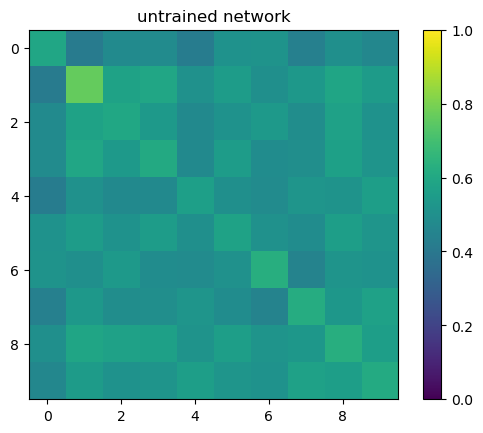

In [ ]:
# First try with untrained network, find the cosine similarities within a class and across classes
test_loader = DataLoader(test_dset, batch_size=50, shuffle=False) # enable persistent_workers=True if more than 1 worker to save CPU
mynet.eval()
test_embeddings = []
test_labels = []
sim_matrix = np.zeros((10,10))
with torch.inference_mode():
    for data_batch in test_loader:
        test_img, test_label = data_batch
        batch_size = test_img.shape[0]
        flat = test_img.reshape(batch_size,-1).to(device, non_blocking=True)
        pred_embeddings = mynet(flat).cpu().numpy().tolist()
        test_embeddings.extend(pred_embeddings)
        test_labels.extend(test_label.numpy().tolist())

test_embeddings = np.array(test_embeddings)
test_embeddings_normed = test_embeddings/np.linalg.norm(test_embeddings, axis=1, keepdims=True)
test_labels = np.array(test_labels)
embeddings = {}
for i in [0,1,2,3,4,5,6,7,8,9]:
    embeddings[i] =test_embeddings_normed[test_labels==i]



# Within class cosine similarity:
for i in [0,1,2,3,4,5,6,7,8,9]:
    sims = embeddings[i]@embeddings[i].T
    np.fill_diagonal(sims, np.nan)
    cur_sim = np.nanmean(sims)
    sim_matrix[i,i] =  cur_sim

    print("Within class {} cosine similarity".format(cur_sim))

print("==================")
for i in [0,1,2,3,4,5,6,7,8,9]:
    for j in [0,1,2,3,4,5,6,7,8,9]:
        if i==j:
            pass
        elif i>j:
            pass
        else:
            sims = embeddings[i]@embeddings[j].T
            cur_sim = np.mean(sims)
            sim_matrix[i,j] =  cur_sim
            sim_matrix[j,i] =  cur_sim
            print("{} and {} cosine similarity {}".format(i,j, np.nanmean(sims)))

plt.imshow(sim_matrix, vmin=0.0, vmax=1.0)
plt.title("untrained network")
plt.colorbar()

Now we will train the network!

Note how we decay the learning rate, so the final learning rate will be half that of the inital learning rate. AdamW is the Adam optimizer with decoupled weight decay. A learning rate of 3e-4 and a weight decay of 1e-2 in AdamW are pretty typical. Note that weight decay in AdamW and SGD work differently in the pytorch implementations. In pytorch, the adamw weight decay is further scaled by learning rate (real weight decay = weight decay * lr) but in SGD, it is not scaled by learning rate.

Also note how we call `mynet.train()` before we start training.

In [ ]:
epochs = 10
device = "cuda"
# device = "cpu"
train_dset = torchvision.datasets.MNIST("./", train=True, transform=mnist_transforms)
train_loader = DataLoader(train_dset, batch_size=50, shuffle=True) # enable persistent_workers=True if more than 1 worker to save CPU

import gc

try:
    del optimizer
    gc.collect()
    torch.cuda.empty_cache()
    # Nuke the optimizer from memory if students try re-running this block
except:
    pass

try:
    del mynet
    gc.collect()
    torch.cuda.empty_cache()
    # Nuke the network from memory if students try re-running this block
except:
    pass

mynet = Model(in_dim=784, out_dim=128, hidden_dim=256)
_ = mynet.to(device)

# This enables training mode, which may affect dropout and stuff
mynet.train(mode=True)
print("Is the network in training mode?", mynet.training)
init_lr = 3e-4
lr_decay_factor = 0.5
optimizer = torch.optim.AdamW(mynet.parameters(), lr=init_lr, weight_decay=1e-2)

loss_tracker = []
for epoch_id in range(1, epochs+1):
    loss_epoch_tracker = 0
    batch_counter = 0
    # decay lr to half that of initial by the end of training
    new_lrate = init_lr * (lr_decay_factor ** (epoch_id / epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lrate
    batches_in_epoch = len(train_loader)
    for data_batch in train_loader:
        optimizer.zero_grad()
        train_img, train_label = data_batch
        batch_size = train_img.shape[0]
        flat = train_img.reshape(batch_size,-1).to(device, non_blocking=True)
        train_label = train_label.to(device, non_blocking=True)
        predicted_results = mynet(flat)
        # Now to compute loss
        similarities = cos_sim(predicted_results)
        label_pos_neg = get_all_pairs_indices(train_label)
        final_loss = torch.mean(pair_based_loss(similarities, label_pos_neg, dcl_loss))
        # assert False
        final_loss.backward()
        optimizer.step()
        loss_cpu_number = final_loss.item()
        loss_epoch_tracker+=loss_cpu_number
        batch_counter +=1
        if batch_counter%500 == 0:
            print("Epoch {}, Batch {}/{}, loss: {}".format(epoch_id, batch_counter, batches_in_epoch, loss_cpu_number))
    print("Epoch average loss {}".format(loss_epoch_tracker/batch_counter))
# Test mode

Is the network in training mode? True
Epoch 1, Batch 500/1200, loss: -4.915890693664551
Epoch 1, Batch 1000/1200, loss: -9.451913833618164
Epoch average loss -4.717957841414027
Epoch 2, Batch 500/1200, loss: -3.451143741607666
Epoch 2, Batch 1000/1200, loss: -6.410930156707764
Epoch average loss -7.38057720584174
Epoch 3, Batch 500/1200, loss: -5.378164291381836
Epoch 3, Batch 1000/1200, loss: -11.727375030517578
Epoch average loss -8.432431429127853
Epoch 4, Batch 500/1200, loss: -10.125375747680664
Epoch 4, Batch 1000/1200, loss: -8.783137321472168
Epoch average loss -9.177340477866432
Epoch 5, Batch 500/1200, loss: -9.148070335388184
Epoch 5, Batch 1000/1200, loss: -7.909364700317383
Epoch average loss -9.407378633121649
Epoch 6, Batch 500/1200, loss: -10.83005428314209
Epoch 6, Batch 1000/1200, loss: -11.682316780090332
Epoch average loss -9.773783509631953
Epoch 7, Batch 500/1200, loss: -10.824069023132324
Epoch 7, Batch 1000/1200, loss: -11.963302612304688
Epoch average loss -10.

Let us now extract the features from the trained network!

In [ ]:
test_loader = DataLoader(test_dset, batch_size=50, shuffle=False) # enable persistent_workers=True if more than 1 worker to save CPU
mynet.eval()
test_embeddings = []
test_labels = []
with torch.inference_mode():
    for data_batch in test_loader:
        test_img, test_label = data_batch
        batch_size = test_img.shape[0]
        flat = test_img.reshape(batch_size,-1).to(device, non_blocking=True)
        pred_embeddings = mynet(flat).cpu().numpy().tolist()
        test_embeddings.extend(pred_embeddings)
        test_labels.extend(test_label.numpy().tolist())
test_labels = np.array(test_labels)

As the network was trained using infoNCE, we will normalize each feature to unit norm. PCA further expects the features to be centered and 1 std.

In [ ]:
test_embeddings = np.array(test_embeddings)
test_embeddings_normed = test_embeddings/np.linalg.norm(test_embeddings, axis=1, keepdims=True)
test_embeddings_normed = test_embeddings_normed-np.mean(test_embeddings_normed, axis=1, keepdims=True)
test_embeddings_normed = test_embeddings_normed/np.std(test_embeddings_normed, axis=1, keepdims=True)
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(test_embeddings)

For TSNE, we just normalize each feature to unit norm due to infoNCE. We will not further center.

In [ ]:
test_embeddings = np.array(test_embeddings)
test_embeddings_normed = test_embeddings/np.linalg.norm(test_embeddings, axis=1, keepdims=True)
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(test_embeddings)
# This takes like a minute, go grab a coffee or somethin

In [ ]:
test_labels.shape, my_embeddings.shape

((10000,), (10000, 2))

Look at how the features for each number are distributed!

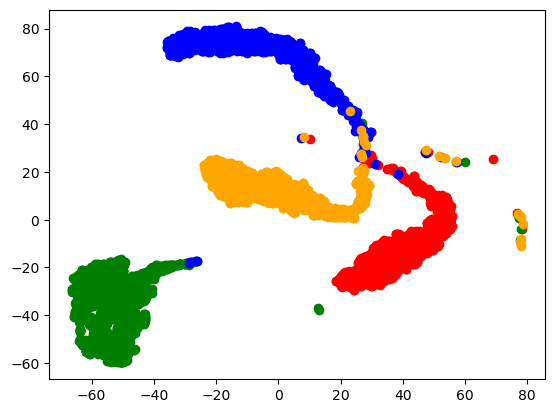

In [ ]:
my_embeddings = tsne_embeddings
# TSNE or PCA?

num = 0
plt.scatter(my_embeddings[test_labels==num, 0], my_embeddings[test_labels==num, 1], c="red")
num = 1
plt.scatter(my_embeddings[test_labels==num, 0], my_embeddings[test_labels==num, 1], c="green")
num = 2
plt.scatter(my_embeddings[test_labels==num, 0], my_embeddings[test_labels==num, 1], c="blue")
num = 3
plt.scatter(my_embeddings[test_labels==num, 0], my_embeddings[test_labels==num, 1], c="orange")

In [ ]:
# First try with untrained network, find the cosine similarities within a class and across classes
test_loader = DataLoader(test_dset, batch_size=50, shuffle=False) # enable persistent_workers=True if more than 1 worker to save CPU
mynet.eval()
test_embeddings = []
test_labels = []
sim_matrix = np.zeros((10,10))
with torch.inference_mode():
    for data_batch in test_loader:
        test_img, test_label = data_batch
        batch_size = test_img.shape[0]
        flat = test_img.reshape(batch_size,-1).to(device, non_blocking=True)
        pred_embeddings = mynet(flat).cpu().numpy().tolist()
        test_embeddings.extend(pred_embeddings)
        test_labels.extend(test_label.numpy().tolist())

test_embeddings = np.array(test_embeddings)
test_embeddings_normed = test_embeddings/np.linalg.norm(test_embeddings, axis=1, keepdims=True)
test_labels = np.array(test_labels)
embeddings = {}
for i in [0,1,2,3,4,5,6,7,8,9]:
    embeddings[i] =test_embeddings_normed[test_labels==i]



# Within class cosine similarity:
for i in [0,1,2,3,4,5,6,7,8,9]:
    sims = embeddings[i]@embeddings[i].T
    np.fill_diagonal(sims, np.nan)
    cur_sim = np.nanmean(sims)
    sim_matrix[i,i] =  cur_sim

    print("Within class {} cosine similarity".format(cur_sim))

print("==================")
for i in [0,1,2,3,4,5,6,7,8,9]:
    for j in [0,1,2,3,4,5,6,7,8,9]:
        if i==j:
            pass
        elif i>j:
            pass
        else:
            sims = embeddings[i]@embeddings[j].T
            cur_sim = np.mean(sims)
            sim_matrix[i,j] =  cur_sim
            sim_matrix[j,i] =  cur_sim
            print("{} and {} cosine similarity {}".format(i,j, np.nanmean(sims)))

Within class 0.9755920137073724 cosine similarity
Within class 0.9770378545420813 cosine similarity
Within class 0.9691096252235208 cosine similarity
Within class 0.941918266773203 cosine similarity
Within class 0.7874379224725241 cosine similarity
Within class 0.9347114334077883 cosine similarity
Within class 0.9433486286002983 cosine similarity
Within class 0.9316282491563304 cosine similarity
Within class 0.9293230568402192 cosine similarity
Within class 0.9524966713953252 cosine similarity
0 and 1 cosine similarity -0.10263515403688611
0 and 2 cosine similarity -0.12834053370320017
0 and 3 cosine similarity -0.0984442179564178
0 and 4 cosine similarity -0.10019996560227115
0 and 5 cosine similarity -0.06583812818409873
0 and 6 cosine similarity -0.09706862163235262
0 and 7 cosine similarity -0.11042222531246008
0 and 8 cosine similarity -0.09754591896415266
0 and 9 cosine similarity -0.09925714980603839
1 and 2 cosine similarity -0.14497824800334602
1 and 3 cosine similarity -0.107

Look at how the cosine similarity has changed!

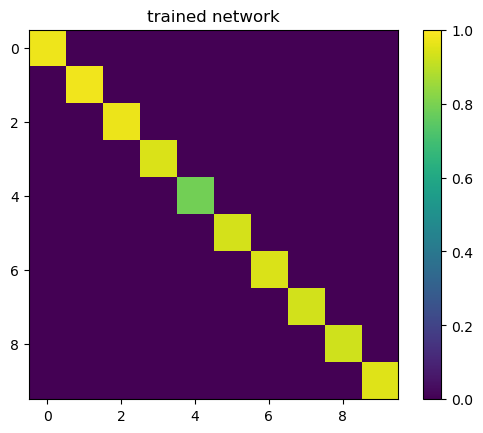

In [ ]:
plt.imshow(sim_matrix, vmin=0.0, vmax=1.0)
plt.title("trained network")
plt.colorbar()